# Clumpy galaxies in GZH SDSS
### Redoing KW's analysis (see kw_notes.txt)

Kyle originally selected galaxies by this metric:

`f_features >= 0.5 & f_clumpy >= 0.5 & f_clumpy_votes >= 20`

He found 144 single-epoch galaxies and 145 coadd galaxies

I've done the same with the file MelG provided: `gzh_sdss.fits`

I found **629** galaxies: 273 single-epoch and 356 coadd. This probably shouldn't be surprising as KW performed this initial search in 2014 before the definitions of "weighted" votes were finalized. 


|             |  single-epoch  | single-epoch - not clumpy| not in single-epoch | Total |
|-------------|----------------|--------------------------|---------------------|-------|
|coadd        |    92          |       160                |       104           |356    |
|coadd- not clumpy |    174    |                          |                     |       |
| not in coadd |    7          |                          |                     |       |
| Total        |   273         |                          |                     | 629   |

*All matching was performed within 3.0"*

After further analysis, I've determined that 3.0'' is not enough to adequately characterize the separation between galaxies which actually are the same between the single-epoch and coadd image depths. I steadily increased the separation until I no longer found matches and it looks like 25'' is a better value. Redoing the table above:


|             |  single-epoch  | single-epoch - not clumpy| Total |
|-------------|----------------|--------------------------|-------|
|coadd        |    111         |       245                |356    |
|coadd- not clumpy |    162    |                          |       |
| Total        |   273         |                          | 629   |


### Making sense of these numbers
For galaxies found in the coadd imaging but not found in single-epoch imaging -- it all makes sense. Coadd imaging is deeper so humans can see additional detail and classify subjects as clumpy that they didn't classify as clumpy in the single-epoch imaging. It also makes sense that not all single-epoch images are found in coadd imaging because of the intial magnitude criterion place on the sample. 

However -- why 174 single-epoch images are classified as clumpy but are NOT classified as clumpy in the coadd imaging is a bit strange. Should look at these briefly. 

### This is **everything** classified as "clumpy" -- can we separate TRUE clumpy with color?
Turns out, probably not. I remade the u-r color histograms that Ali/Steve made last year (see below) and there is NO clear dilineation between the true blue clumpy sample and the known red-elliptical interloper sample which is definitely the majority. I'll have to go through these 600 galaxies by eye. :( But at least it's not looking at 50K!!

I went through the 629 "clumpy" galaxies by eye marking those which were defintely NOT groups of red ellipticals or obvious double nuclei/mergers. This means the clumpy sample will still contain some questionable galaxies which may not have the type of clumps we're looking for but they'll all be blue, individual galaxies. These 224 galaxies are saved in `/data/gzh_sdss_strictclumpy_all_trueclumpy.fits`

I also determined which of these galaxies have duplicates among their own depth. 
* 106 unique single-epoch galaxies (119 total)
* 93 unqiue coadd depth galaxies (105 total)


## Relaxing some of KW's criteria

#### Relaxing f_features 
    1. 0.3 <= f_features < 0.4 :  21 additional galaxies. None are true "clumpy"
    2. 0.4 <= f_features < 0.5 : 271 additional galaxies. Perhaps 9 are truly clumpy.
    
#### Relaxing f_clumpy
    1. 0.3 <= f_clumpy < 0.4 : 314 additional galaxies. 
    2. 0.4 <= f_clumpy < 0.5 : 169 additional galaxies.

#### Relaxing f_clumpy_count
    1. 10 <= f_clumpy_count < 20: 15 additional galaxies. 
  
  

In [1]:
from astropy.table import Table
from astropy.coordinates import SkyCoord
from astropy import units as u
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

/home/oxymoronic/.local/lib/python2.7/site-packages/IPython/kernel/__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated. You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)


In [10]:
gzh_sdss = Table.read('../data/gzh_sdss.fits')

In [23]:
# Add a column that easily separates single-epoch and coadd subjects
depth = np.unique(gzh_sdss['Table'])
single_idx = gzh_sdss['Table'] == depth[1]
single = gzh_sdss[single_idx]

coadd_idx= gzh_sdss['Table'] == depth[0]
coadd = gzh_sdss[coadd_idx]

print len(single), len(coadd)

gzh_sdss['coadd'] = coadd_idx

21522 30339


In [59]:
# Verify that the single-epoch imaging has co-add counterparts as claimed in Willett2017

import astropy.units as u
from astropy.coordinates import SkyCoord

sample = SkyCoord(ra=single['RA']*u.deg, dec=single['DEC']*u.deg)
catalog = SkyCoord(ra=coadd['RA']*u.deg, dec=coadd['DEC']*u.deg)
idx, d2d, d3d = sample.match_to_catalog_sky(catalog)
idx2, d2d2, d3d2 = catalog.match_to_catalog_sky(sample)

within25as = (catalog[idx].separation(sample)<25*u.arcsec)
single_matches = single[within25as]
coadd_matches = coadd[idx[within25as]]

within25as2 = (sample[idx2].separation(catalog)<25*u.arcsec)
coadd_matches2 = coadd[within25as2]
single_matches2 = single[idx2[within25as2]]

print len(single) - len(single_matches), "single-depth subjects don't seem to have a co-add counterpart"

# Add a column that denotes which subjects have a match in the other depth imaging
gzh_sdss['matched25as'] = np.concatenate([within25as, within25as2])

167 single-depth subjects don't seem to have a co-add counterpart


In [ ]:
587734303802392898
8647474690860843214
8647474692504093423
8647474693040701887
8647475122518098006

In [70]:
# Add a column that denotes whether subject is "clumpy" BY WHAT DEFINITION?
featured = 't01_smooth_or_features_a02_features_or_disk_weighted_fraction'
clumpy = 't12_clumpy_a01_yes_weighted_fraction'
count = 't12_clumpy_total_count'
embedded = 't18_clumps_embedded_a01_yes_weighted_fraction'

# My and Kyle's initial definition: f_feat >= 0.5 & f_clumpy >= 0.5 
clumps1 = (gzh_sdss[clumpy] >= 0.5) & (gzh_sdss[count] >= 20) & (gzh_sdss[featured] >= 0.5)
print np.sum(clumps1)

# Test out whether "embedded" can help isolate properly clumpy galaxies
clumps2 = (gzh_sdss[clumpy] >= 0.5) & (gzh_sdss[count] >= 20) & \
          (gzh_sdss[featured] >= 0.5) & (gzh_sdss[embedded] >= 0.5)
print np.sum(clumps2)

# From Willett & Galloway 2017: f_feat > 0.23 & f_clumpy > 0.8
clumps3 = (gzh_sdss[clumpy] > 0.8) & (gzh_sdss[count] >= 20) & (gzh_sdss[featured] > 0.23)
print np.sum(clumps3)

clumps4 = (gzh_sdss[clumpy] > 0.8) & (gzh_sdss[count] >= 20) & \
          (gzh_sdss[featured] > 0.23) & (gzh_sdss[embedded] >= 0.5)
print np.sum(clumps4)

629
581
370
322


In [9]:
clumpy = Table.read('../data/gzh_sdss_strictclumpy_trueclumpy_sdssdata.fits')

224

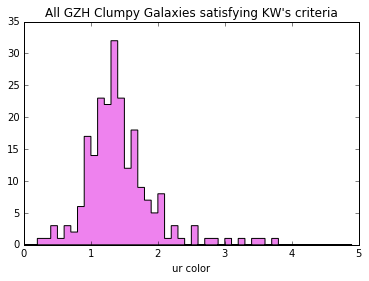

In [10]:

bins = np.arange(0.,5.,0.1)
fig, ax = plt.subplots()
ax.hist(clumpy['urcolor'],bins=bins,histtype='stepfilled',color='violet')
ax.set_xlabel('ur color')
ax.set_title("All GZH Clumpy Galaxies satisfying KW's criteria")

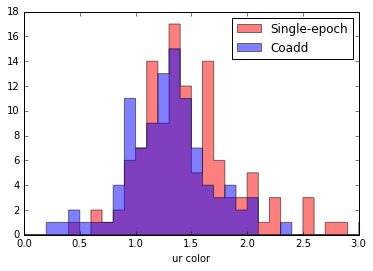

In [13]:
# But maybe there's a difference if we separate single-epoch from coadd?
single = clumpy['Table'] == 'sdss_single  '
fig, ax = plt.subplots()
ax.hist(clumpy['urcolor'][single], bins=bins, histtype='stepfilled',color='red',
        alpha=0.5, label='Single-epoch')
ax.hist(clumpy['urcolor'][~single], bins=bins, histtype='stepfilled',color='blue',
        alpha=0.5, label='Coadd')
ax.set_xlabel('ur color')
ax.set_xlim(0,3)
ax.legend(loc='best')

In [34]:
# Remove duplicates! --------------------------------------------#
# ----> SEPARATELY from single-epoch and coadd imaging

clumpy = Table.read('../data/gzh_sdss_strictclumpy_all_trueclumpy.fits')

single_mask = clumpy['Table']=='sdss_single  '
single = clumpy[single_mask]
coadd = clumpy[~single_mask]


c1_single = SkyCoord(single['RA']*u.degree, single['DEC']*u.degree)
c2_single = SkyCoord(single['RA']*u.degree, single['DEC']*u.degree)
idxc1_single, idxc2_single, d2d, d3d = c1_single.search_around_sky(c2_single, 25*u.arcsec)

print "These are the indices of duplicate pairs in single-epoch:"
single_idx = np.where(np.bincount(idxc1_single)==1)

c1_coadd = SkyCoord(coadd['RA']*u.degree, coadd['DEC']*u.degree)
c2_coadd = SkyCoord(coadd['RA']*u.degree, coadd['DEC']*u.degree)
idxc1_coadd, idxc2_coadd, d2d, d3d = c1_coadd.search_around_sky(c2_coadd, 25*u.arcsec)

print "These are the duplicate images"
print np.where(np.bincount(idxc1_coadd)>1)

single.write('../data/gzh_sdss_strictclumpy_single.fits',overwrite=True)
coadd.write('../data/gzh_sdss_strictclumpy_coadd.fits',overwrite=True)

These are the indices of duplicate pairs in single-epoch:
These are the indices of unique images
(array([  5,   6,  13,  14,  15,  31,  32,  39,  40,  46,  47,  60,  61,
        70,  71,  75,  76, 100, 101, 102, 104]),)


In [38]:
single_dupes = np.array([3,16,22,27,30,54,58,78,83,99,101,103,113])
coadd_dupes = np.array([6,14,15,32,40,47,61,71,76,101,103,104])

sdupe_mask = np.ones(len(single), dtype='bool')
sdupe_mask[single_dupes] = False

cdupe_mask = np.ones(len(coadd), dtype='bool')
cdupe_mask[coadd_dupes] = False

print len(coadd[cdupe_mask]), len(single[sdupe_mask])

# Write out coordinates and identifer for looking up SDSS spectra
ss = single['RA','DEC'][sdupe_mask]
#ss['OBJID']=ss['survey_id']
#ss.remove_column('survey_id')
ss.write('../data/gzh_single_nodupes_coordlist.csv',format='ascii.csv')

cc = coadd['RA','DEC'][cdupe_mask]
#cc['OBJID']=cc['survey_id']
#cc.remove_column('survey_id')
cc.write('../data/gzh_coadd_nodupes_coordlist.csv',format='ascii.csv')



93 106


In [8]:
import astropy.units as u
from astropy.coordinates import SkyCoord

catalog = SkyCoord(ra=GSWLC['RA']*u.deg, dec=GSWLC['DEC']*u.deg)
sample = SkyCoord(ra=clumpy['RA']*u.deg, dec=clumpy['DEC']*u.deg)
idx, d2d, d3d = sample.match_to_catalog_sky(catalog)

In [ ]:
close_mask = (catalog[idx].separation(sample)<20*u.arcsec)
close_matches_in_clumpy = clumpy[close_mask]
close_matches_in_GSWLC = GSWLC[idx[close_mask]]